In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from Bio import PDB

# Load Ground truth

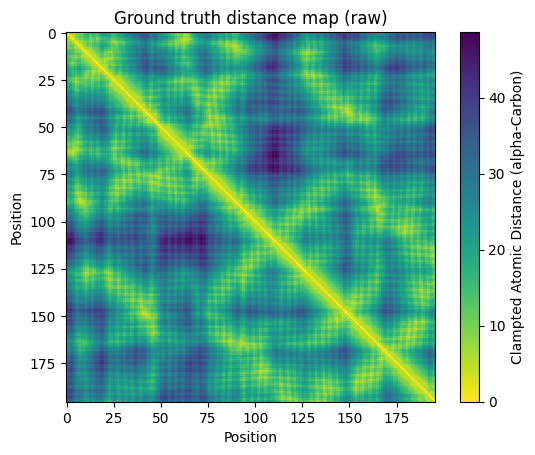

In [8]:

def calculate_contact_map_binary(pdb_file, cutoff=8.0):
    # Initialize parser
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_file)
    
    # Get alpha carbon atoms
    ca_atoms = []
    for model in structure:
        for chain in model:
            for residue in chain:
                if "CA" in residue:
                    ca_atoms.append(residue["CA"])

    # Get sequence length
    sequence_length = len(ca_atoms)
    
    # Initialize contact map
    contact_map = np.zeros((sequence_length, sequence_length), dtype=int)
    
    # Calculate distances and populate contact map
    for i in range(sequence_length):
        for j in range(i + 1, sequence_length):
            distance = ca_atoms[i] - ca_atoms[j]
            if distance <= cutoff:
                contact_map[i, j] = 1
                contact_map[j, i] = 1  # Symmetric matrix

    return contact_map

def calculate_distance_map(pdb_file):
    # Initialize parser
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_file)
    
    # Get alpha carbon atoms
    ca_atoms = []
    for model in structure:
        for chain in model:
            for residue in chain:
                if "CA" in residue:
                    ca_atoms.append(residue["CA"])

    # Get sequence length
    sequence_length = len(ca_atoms)
    
    # Initialize distance map
    distance_map = np.zeros((sequence_length, sequence_length), dtype=float)
    
    # Calculate distances and populate distance map
    for i in range(sequence_length):
        for j in range(i + 1, sequence_length):
            distance = ca_atoms[i] - ca_atoms[j]
            distance_map[i, j] = distance
            distance_map[j, i] = distance  # Symmetric matrix

    return distance_map

# Path to your uploaded PDB file
pdb_file_path = 'data/1TX4_A.pdb'
contact_map_ground_truth = calculate_distance_map(pdb_file_path)

# Map values above 20 to 40
threshold_value = 20
new_value = 40
mapped_matrix = np.where(contact_map_ground_truth > threshold_value, new_value, contact_map_ground_truth)
# plt.figure(figsize=(8, 8))
plt.imshow(contact_map_ground_truth, cmap="viridis_r", interpolation="nearest")
plt.colorbar(label="Clampted Atomic Distance (alpha-Carbon)")
plt.title("Ground truth distance map (raw)")
plt.xlabel("Position")
plt.ylabel("Position")
plt.show()


(array([196.,   0.,   0.,   0.,   0.,   0.,   0., 390.,   4.,  20., 254.,
        382., 246., 158., 136., 134., 206., 356., 362., 320., 502., 570.,
        494., 410., 546., 592., 594., 608., 670., 664., 724., 792., 688.,
        742., 740., 732., 722., 782., 782., 734., 762., 714., 858., 798.,
        724., 730., 756., 736., 724., 754., 772., 754., 724., 694., 670.,
        608., 690., 620., 552., 624., 576., 522., 554., 496., 494., 450.,
        426., 446., 390., 390., 374., 346., 286., 262., 218., 208., 214.,
        158., 130., 118., 106.,  88.,  80.,  68.,  68.,  60.,  64.,  42.,
         34.,  36.,  40.,  30.,  30.,  18.,  18.,  28.,  12.,  10.,   4.,
          6.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.

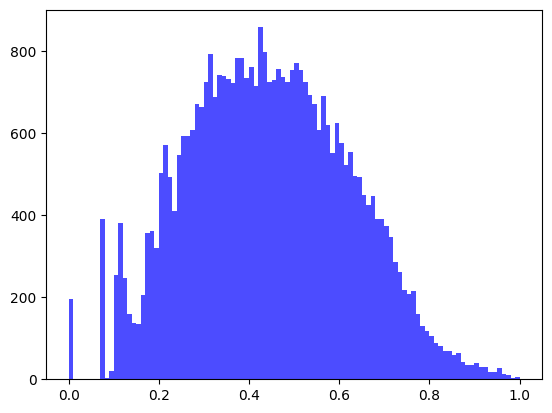

In [46]:
#plot distribution of distances
plt.hist(contact_map_ground_truth_normalized.flatten(), bins=100, color='blue', alpha=0.7)

(array([196.,   0.,   0.,   0.,   0.,   0.,   0., 390.,   4.,  20., 254.,
        382., 246., 158., 136., 134., 206., 356., 362., 320., 502., 570.,
        494., 410., 546., 592., 594., 608., 670., 664., 724., 792., 688.,
        742., 740., 732., 722., 782., 782., 734., 762., 714., 858., 798.,
        724., 730., 756., 736., 724., 754., 772., 754., 724., 694., 670.,
        608., 690., 620., 552., 624., 576., 522., 554., 496., 494., 450.,
        426., 446., 390., 390., 374., 346., 286., 262., 218., 208., 214.,
        158., 130., 118., 106.,  88.,  80.,  68.,  68.,  60.,  64.,  42.,
         34.,  36.,  40.,  30.,  30.,  18.,  18.,  28.,  12.,  10.,   4.,
          6.]),
 array([ 0.        ,  0.48617054,  0.97234108,  1.45851162,  1.94468216,
         2.4308527 ,  2.91702324,  3.40319378,  3.88936432,  4.37553486,
         4.8617054 ,  5.34787594,  5.83404648,  6.32021702,  6.80638756,
         7.2925581 ,  7.77872864,  8.26489918,  8.75106972,  9.23724026,
         9.7234108 , 10.20

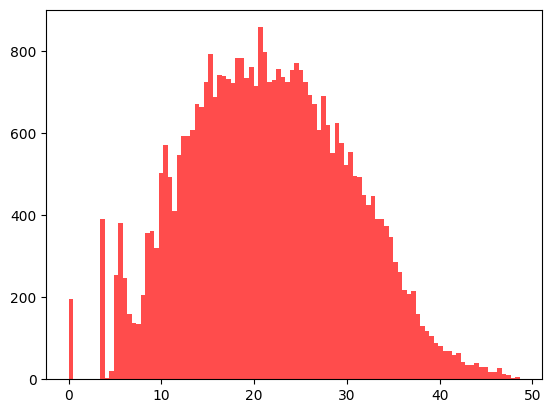

In [45]:
# plot distribution of distances after clamping
plt.hist(contact_map_ground_truth.flatten(), bins=100, color='red', alpha=0.7)

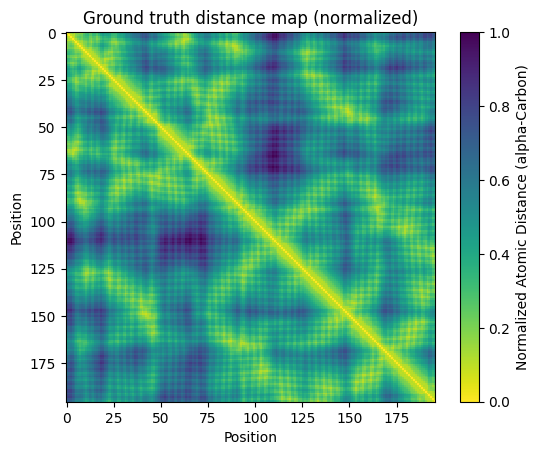

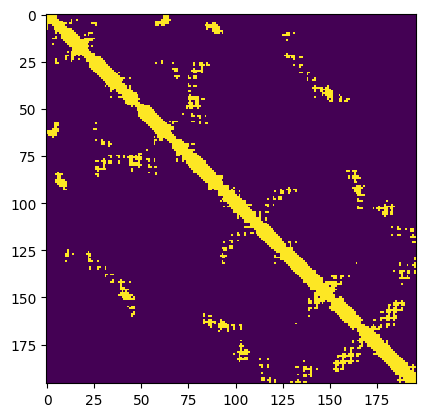

In [76]:
# normalzed using min-max scaling

contact_map_ground_truth_normalized = (contact_map_ground_truth - contact_map_ground_truth.min()) / (contact_map_ground_truth.max() - contact_map_ground_truth.min())
plt.imshow(contact_map_ground_truth_normalized, cmap="viridis_r", interpolation="nearest")
plt.colorbar(label="Normalized Atomic Distance (alpha-Carbon)")
plt.title("Ground truth distance map (normalized)")
plt.xlabel("Position")
plt.ylabel("Position")
plt.show()

# remove score > 0.5
contact_map_ground_truth_binary = np.where(contact_map_ground_truth_normalized > 0.2, 1, 0)
plt.imshow(contact_map_ground_truth_binary, cmap="viridis_r", interpolation="nearest")


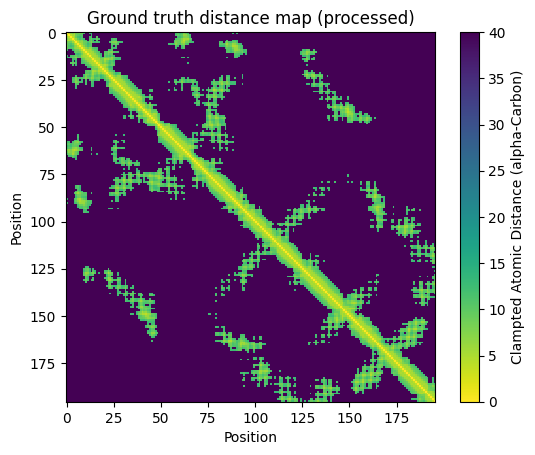

In [9]:
# Map values above 20 to 40
threshold_value = 13
new_value = 40
mapped_matrix = np.where(contact_map_ground_truth > threshold_value, new_value, contact_map_ground_truth)

plt.imshow(mapped_matrix, cmap="viridis_r", interpolation="nearest")
plt.colorbar(label="Clampted Atomic Distance (alpha-Carbon)")
plt.title("Ground truth distance map (processed)")
plt.xlabel("Position")
plt.ylabel("Position")
plt.show()

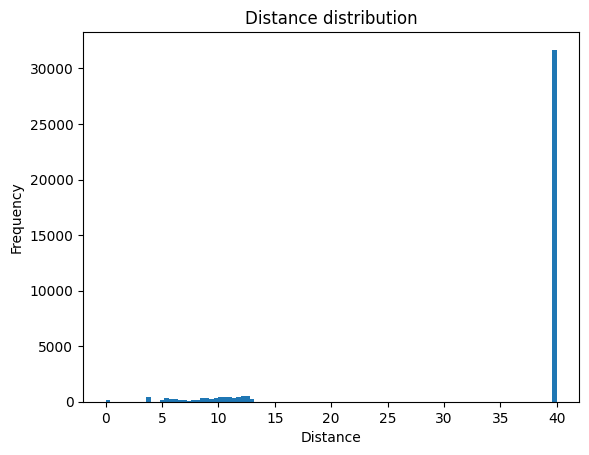

In [28]:
# print contact_map_ground_truth distribution
plt.hist(mapped_matrix.flatten(), bins=100)
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.title("Distance distribution")
plt.show()


# Load Predicted Matrix

In [5]:
# Open the HDF5 file in read mode
file_path = 'out/1TX4-A_esm2_t33_650M_UR50D.h5'  # replace with your file path
with h5py.File(file_path, 'r') as h5_file:    
    # Access a specific dataset
    dataset = h5_file['1TX4-A']  # replace with your dataset name
    contact_map = dataset[:]


In [35]:
def contact_map_to_distances(contact_map, n_bins=90, min_dist=1.0, max_dist=40.0):
    """
    Enhanced contact map to distance conversion with improved physical modeling
    """
    # Create distance bins with non-linear spacing for better short-range resolution
    bins_short = np.linspace(min_dist, 8.0, 30)  # More bins for short distances
    bins_med = np.linspace(8.0, 15.0, 30)  # More bins for medium distances
    bins_long = np.linspace(15.0, max_dist, 31)  # Fewer bins for long distances
    bin_edges = np.unique(np.concatenate([bins_short, bins_med, bins_long]))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    L = contact_map.shape[0]
    distance_probs = np.zeros((L, L, len(bin_centers)))
    
    # Pre-compute sequence separation matrix
    seq_sep = np.abs(np.arange(L)[:, None] - np.arange(L)[None, :])
    
    for i in range(L):
        for j in range(L):
            if i != j:
                contact_prob = contact_map[i,j]
                sep = seq_sep[i,j]
                
                # Enhanced distance prediction based on contact probability and sequence separation
                if sep < 4:  # Very close in sequence
                    mu = 1  # Cα-Cα distance
                    sigma = 0.5
                elif sep < 8:  # Local structure
                    if contact_prob > 0.7:  # Helical contacts
                        mu = 5.5
                        sigma = 1.0
                    else:
                        mu = 7.0
                        sigma = 1.5
                else:  # Non-local structure
                    if contact_prob > 0.9:
                        mu = 1.0
                        sigma = 1.0
                    elif contact_prob > 0.7:
                        mu = 3.0
                        sigma = 2.0
                    elif contact_prob > 0.5:
                        mu = 10.0
                        sigma = 3.0
                    elif contact_prob > 0.3:
                        mu = 20.0
                        sigma = 4.0
                    elif contact_prob > 0.1:
                        mu = 30.0
                        sigma = 5.0
                    else:
                        mu =40.0
                        sigma = 6.0
                
                # Secondary structure considerations
                if sep in [3, 4]:  # Potential helical contacts
                    if contact_prob > 0.4:
                        mu = min(mu, 6.0)
                        sigma = 1.5
                elif sep in range(5, 9):  # Potential strand-strand contacts
                    if contact_prob > 0.4:
                        mu = min(mu, 7.0)
                        sigma = 2.0
                
                # Distance distribution with physical constraints
                bin_probs = np.exp(-0.5 * ((bin_centers - mu)/sigma)**2)
                
                # Apply physical constraints
                bin_probs[bin_centers < 3.8] = 0  # Minimum possible distance
                
                # Normalize probabilities
                if np.sum(bin_probs) > 0:
                    bin_probs = bin_probs / np.sum(bin_probs)
                else:
                    # Fallback to uniform distribution within physical limits
                    valid_bins = (bin_centers >= 3.8)
                    bin_probs[valid_bins] = 1.0 / np.sum(valid_bins)
                
                distance_probs[i,j] = bin_probs
    
    # Calculate distances using weighted average
    distances = np.sum(bin_centers[None,None,:] * distance_probs, axis=2)
    
    # Symmetrize matrices
    distances = (distances + distances.T) / 2
    distance_probs = (distance_probs + np.transpose(distance_probs, (1,0,2))) / 2
    
    # Final physical constraints
    np.fill_diagonal(distances, 0.0)
    
    # Smooth transitions in distance matrix
    from scipy.ndimage import gaussian_filter
    distances = gaussian_filter(distances, sigma=0.5)
    
    return distances, distance_probs, bin_edges

(array([1.600e+01, 1.180e+02, 6.480e+02, 2.284e+03, 5.370e+03, 7.852e+03,
        6.672e+03, 4.270e+03, 2.510e+03, 1.420e+03, 9.880e+02, 7.500e+02,
        6.520e+02, 4.740e+02, 4.100e+02, 3.360e+02, 3.380e+02, 2.920e+02,
        2.660e+02, 2.300e+02, 2.160e+02, 1.520e+02, 1.300e+02, 1.580e+02,
        1.260e+02, 1.300e+02, 1.060e+02, 8.200e+01, 9.600e+01, 1.080e+02,
        9.800e+01, 6.600e+01, 6.000e+01, 6.000e+01, 8.000e+01, 4.600e+01,
        4.600e+01, 5.200e+01, 4.200e+01, 7.400e+01, 4.600e+01, 6.200e+01,
        5.000e+01, 3.000e+01, 3.000e+01, 4.200e+01, 2.600e+01, 1.600e+01,
        3.600e+01, 3.800e+01, 2.200e+01, 1.800e+01, 2.000e+01, 2.000e+01,
        1.000e+01, 8.000e+00, 8.000e+00, 1.800e+01, 4.000e+00, 6.000e+00,
        4.000e+00, 6.000e+00, 8.000e+00, 6.000e+00, 6.000e+00, 6.000e+00,
        4.000e+00, 0.000e+00, 2.000e+00, 8.000e+00, 2.000e+00, 4.000e+00,
        4.000e+00, 0.000e+00, 4.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 0.000e+0

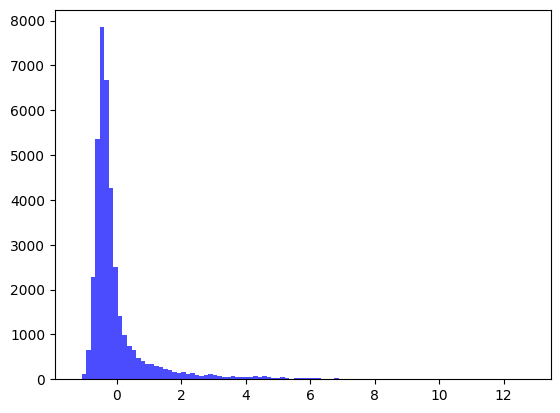

In [18]:
# print contact_map distribution

plt.hist(contact_map.flatten(), bins=100, color='blue', alpha=0.7, label='Contact map')

(array([   2.,    4.,    6.,   14.,   22.,   42.,   58.,   86.,  150.,
         220.,  282.,  378.,  540.,  728.,  878., 1038., 1240., 1542.,
        1512., 1784., 1806., 1882., 1840., 1728., 1634., 1468., 1350.,
        1256., 1122., 1010.,  830.,  752.,  676.,  554.,  460.,  610.,
         392.,  352.,  318.,  322.,  250.,  220.,  270.,  212.,  198.,
         206.,  188.,  154.,  170.,  158.,  166.,  154.,  144.,  154.,
         114.,  116.,  126.,  102.,  116.,  112.,  122.,   86.,   84.,
         102.,   96.,   82.,  132.,   96.,   86.,   90.,   96.,   90.,
          74.,  106.,   80.,   90.,   90.,   84.,   78.,  106.,   52.,
          86.,   58.,   60.,   86.,   90.,   86.,   74.,  108.,   62.,
          88.,   66.,  106.,  116.,  112.,  104.,  150.,  134.,  268.,
         422.]),
 array([0.22891013, 0.236621  , 0.24433187, 0.25204274, 0.25975361,
        0.26746448, 0.27517535, 0.28288622, 0.29059709, 0.29830796,
        0.30601883, 0.31372971, 0.32144058, 0.32915145, 0.33686232

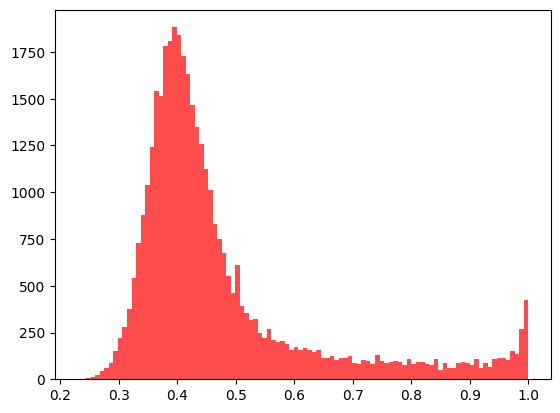

In [30]:
# using sigmoid function to normalize the contact map
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

contact_map_normalized = sigmoid(contact_map)
plt.hist(contact_map_normalized.flatten(), bins=100, color='red', alpha=0.7, label='Normalized contact map')

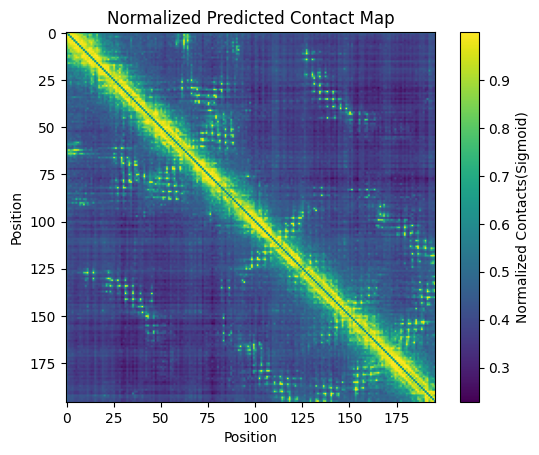

In [81]:

# Plot the result
plt.imshow(contact_map_normalized, cmap="viridis")
plt.colorbar(label="Normalized Contacts(Sigmoid)")
plt.xlabel("Position")
plt.ylabel("Position")
plt.title("Normalized Predicted Contact Map")
# plt.savefig(f"amplified_test/map_{af}_{max_gt}")
# plt.clf()
plt.show()

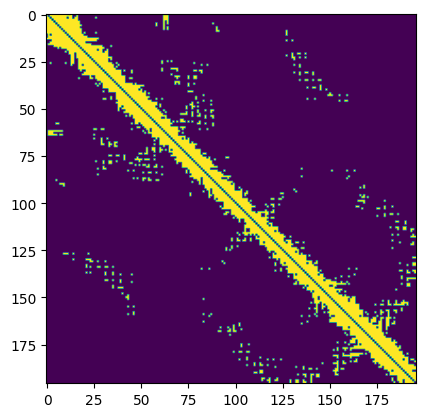

In [78]:
# get contact map < 0.5
contact_map_binary = np.where(contact_map_normalized > 0.70, 1, 0)
plt.imshow(contact_map_binary, cmap="viridis")






In [ ]:
# save the gif

# create gif of contact map from 0 to 1

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ims = []
for i in range(0, 100):
    im = plt.imshow(contact_map_normalized, cmap="viridis", animated=True)
    ims.append([im])


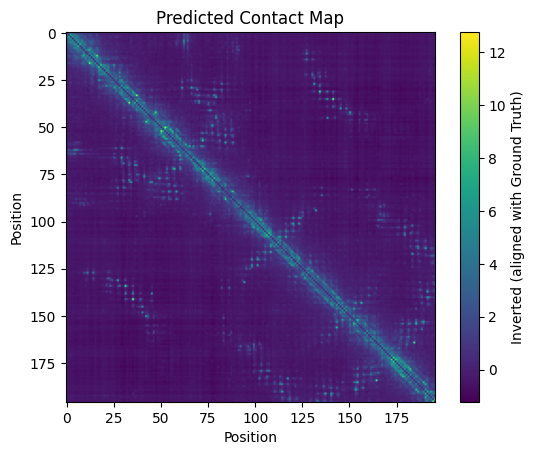

In [80]:

# Plot the result
plt.imshow(contact_map, cmap="viridis")
plt.colorbar(label="Inverted (aligned with Ground Truth)")
plt.xlabel("Position")
plt.ylabel("Position")
plt.title("Predicted Contact Map")
# plt.savefig(f"amplified_test/map_{af}_{max_gt}")
# plt.clf()
plt.show()

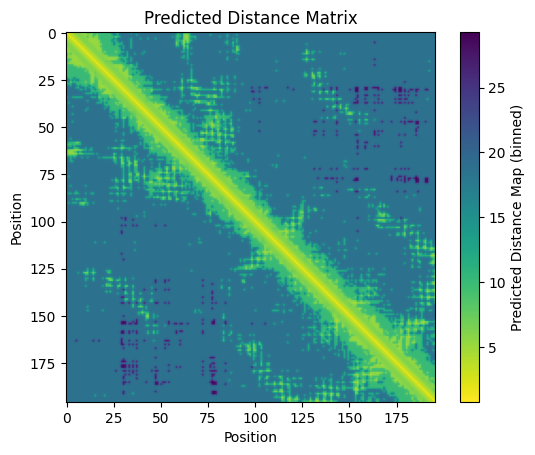

In [36]:
distance = contact_map_to_distances(contact_map_normalized)
plt.imshow(distance[0], cmap="viridis_r")
plt.colorbar(label="Predicted Distance Map (binned)")
plt.xlabel("Position")
plt.ylabel("Position")
plt.title("Predicted Distance Matrix")
plt.show()



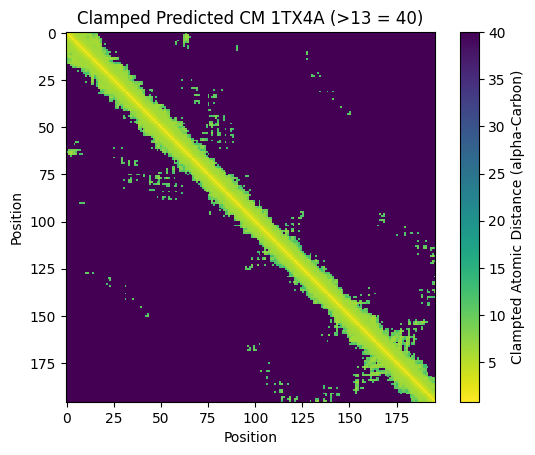

In [109]:
mapped_matrix_predict = np.where(distance[0] > threshold_value, new_value, distance[0])

plt.imshow(mapped_matrix_predict, cmap="viridis_r", interpolation="nearest")
plt.colorbar(label="Clampted Atomic Distance (alpha-Carbon)")
plt.title("Clamped Predicted CM 1TX4A (>13 = 40)")
plt.xlabel("Position")
plt.ylabel("Position")
plt.show()

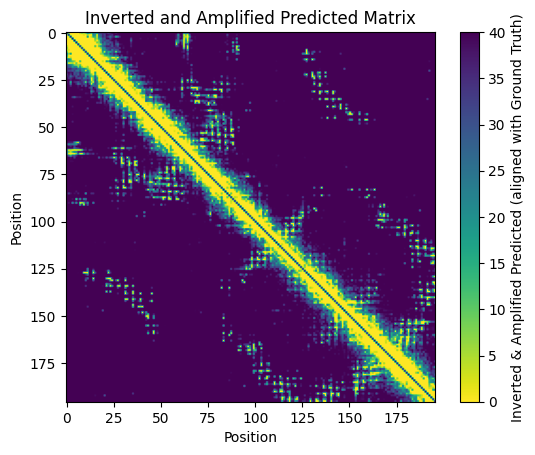

In [110]:

# Amplify the predicted matrix (you can adjust the factor as needed)
amplification_factor = 30 # Value more or less arbitrary right now
amplified_predicted_matrix = contact_map * amplification_factor

# Invert the amplified matrix valu40es to match the ground truth range
max_ground_truth = 40 # Value more or less arbitrary right now
inverted_amplified_matrix = max_ground_truth - amplified_predicted_matrix

# Clip values to avoid negative numbers if necessary
inverted_amplified_matrix = np.clip(inverted_amplified_matrix, 0, max_ground_truth)

# Plot the result
plt.imshow(inverted_amplified_matrix, cmap="viridis_r")
plt.colorbar(label="Inverted & Amplified Predicted (aligned with Ground Truth)")
plt.xlabel("Position")
plt.ylabel("Position")
plt.title("Inverted and Amplified Predicted Matrix")
# plt.savefig(f"amplified_test/map_{af}_{max_gt}")
# plt.clf()
plt.show()

# Calculate IDDT

In [111]:
import numpy as np

def calculate_iddt(matrix_A, matrix_B, threshold=8.0, tolerance=2.0):
    # Step 1: Convert to binary contact matrices based on threshold
    contact_A = (matrix_A < threshold).astype(int)
    contact_B = (matrix_B < threshold).astype(int)
    
    # Step 2: Calculate absolute differences
    absolute_differences = np.abs(matrix_A - matrix_B)

    # Step 3: Calculate IDDT scores for each contact
    iddt_scores = np.where(absolute_differences <= tolerance, 1, 0)
    
    # Step 4: Calculate the average IDDT score
    iddt_score = np.sum(iddt_scores) / (matrix_A.shape[0] * matrix_A.shape[1])
    
    return iddt_score

iddt = calculate_iddt(distance[0], contact_map_ground_truth)
iddt_mapped = calculate_iddt(distance[0], mapped_matrix)
print("IDDT Score:", iddt, iddt_mapped)


IDDT Score: 0.15556018325697626 0.05226988754685548


In [112]:
import numpy as np

def calculate_iddt(dist_observed, dist_predicted, thresholds=[0.5, 1, 2, 4]):
    """
    Calculate IDDT score between observed and predicted distance matrices
    
    Parameters:
    -----------
    dist_observed : np.ndarray
        LxL matrix of observed distances
    dist_predicted : np.ndarray
        LxL matrix of predicted distances
    thresholds : list
        Distance difference thresholds in Angstroms
        
    Returns:
    --------
    float
        IDDT score (between 0 and 1)
    """
    if dist_observed.shape != dist_predicted.shape:
        raise ValueError("Observed and predicted distance matrices must have same shape")
    
    L = dist_observed.shape[0]
    scores = []
    
    # Create mask for valid distances (excluding diagonal and possibly invalid values)
    mask = np.ones((L, L), dtype=bool)
    np.fill_diagonal(mask, False)
    mask = mask & ~np.isnan(dist_observed) & ~np.isnan(dist_predicted)
    
    # Calculate absolute differences
    diff_matrix = np.abs(dist_observed - dist_predicted)
    
    # Calculate scores for each threshold
    for threshold in thresholds:
        # Count pairs within threshold
        within_threshold = (diff_matrix <= threshold) & mask
        score = np.sum(within_threshold) / np.sum(mask)
        scores.append(score)
    
    # IDDT is average over all thresholds
    iddt_score = np.mean(scores)
    
    return iddt_score

# You can also get per-residue IDDT scores
def calculate_per_residue_iddt(dist_observed, dist_predicted, thresholds=[0.5, 1, 2, 4]):
    """
    Calculate per-residue IDDT scores
    
    Parameters:
    -----------
    dist_observed : np.ndarray
        LxL matrix of observed distances
    dist_predicted : np.ndarray
        LxL matrix of predicted distances
    thresholds : list
        Distance difference thresholds in Angstroms
        
    Returns:
    --------
    np.ndarray
        Array of per-residue IDDT scores
    """
    L = dist_observed.shape[0]
    per_residue_scores = np.zeros(L)
    
    # Create mask for valid distances
    mask = np.ones((L, L), dtype=bool)
    np.fill_diagonal(mask, False)
    mask = mask & ~np.isnan(dist_observed) & ~np.isnan(dist_predicted)
    
    # Calculate absolute differences
    diff_matrix = np.abs(dist_observed - dist_predicted)
    
    # Calculate per-residue scores
    for i in range(L):
        residue_scores = []
        for threshold in thresholds:
            # Count pairs within threshold for this residue
            within_threshold = (diff_matrix[i] <= threshold) & mask[i]
            score = np.sum(within_threshold) / np.sum(mask[i])
            residue_scores.append(score)
        per_residue_scores[i] = np.mean(residue_scores)
    
    return per_residue_scores


# Calculate global IDDT
iddt_score = calculate_iddt(mapped_matrix, distance[0])
print(f"Global IDDT score: {iddt_score}")

# Calculate per-residue IDDT
per_residue_scores = calculate_per_residue_iddt(mapped_matrix, distance[0])
print(f"Average per-residue IDDT score: {np.mean(per_residue_scores)}")
print(f"Per-residue score range: {np.min(per_residue_scores)} - {np.max(per_residue_scores)}")

Global IDDT score: 0.04552590266875981
Average per-residue IDDT score: 0.04552590266875981
Per-residue score range: 0.017948717948717947 - 0.08076923076923077


# Maybe other metrics

In [116]:
import numpy as np
from scipy import stats
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_protein_metrics(dist_observed, dist_predicted):
    """
    Calculate various protein structural metrics from distance matrices
    
    Parameters:
    -----------
    dist_observed : np.ndarray
        LxL matrix of observed distances
    dist_predicted : np.ndarray
        LxL matrix of predicted distances
    
    Returns:
    --------
    dict
        Dictionary containing various metrics
    """
    metrics = {}
    
    # Remove diagonal and get valid indices
    mask = ~np.eye(dist_observed.shape[0], dtype=bool)
    valid_mask = mask & ~np.isnan(dist_observed) & ~np.isnan(dist_predicted)
    
    obs_flat = dist_observed[valid_mask]
    pred_flat = dist_predicted[valid_mask]
    
    # 1. Basic Distance Metrics
    metrics['rmsd'] = np.sqrt(np.mean((obs_flat - pred_flat)**2))
    metrics['mae'] = np.mean(np.abs(obs_flat - pred_flat))
    
    # 2. Correlations
    metrics['pearson'] = stats.pearsonr(obs_flat, pred_flat)[0]
    metrics['spearman'] = stats.spearmanr(obs_flat, pred_flat)[0]
    
    # 3. Contact-based metrics at different thresholds
    thresholds = [1.0, 5.0, 10.0, 15.0]  # Common contact thresholds in Angstroms
    for threshold in thresholds:
        obs_contacts = dist_observed <= threshold
        pred_contacts = dist_predicted <= threshold
        
        # Calculate metrics for this threshold
        metrics[f'precision_{threshold}A'] = precision_score(
            obs_contacts[valid_mask], 
            pred_contacts[valid_mask]
        )
        metrics[f'recall_{threshold}A'] = recall_score(
            obs_contacts[valid_mask], 
            pred_contacts[valid_mask]
        )
        metrics[f'f1_{threshold}A'] = f1_score(
            obs_contacts[valid_mask], 
            pred_contacts[valid_mask]
        )
    
    # 4. Distance ranges analysis
    ranges = [(0, 8), (8, 15), (15, 30), (30, float('inf'))]
    for start, end in ranges:
        obs_range = (dist_observed >= start) & (dist_observed < end)
        pred_range = (dist_predicted >= start) & (dist_predicted < end)
        
        if np.sum(obs_range[valid_mask]) > 0:  # Avoid division by zero
            metrics[f'accuracy_{start}_{end}A'] = np.sum(
                (obs_range & pred_range)[valid_mask]
            ) / np.sum(obs_range[valid_mask])
    
    # 5. Per-residue accuracy
    L = dist_observed.shape[0]
    per_residue_rmsd = np.zeros(L)
    for i in range(L):
        valid_i = valid_mask[i]
        if np.sum(valid_i) > 0:
            per_residue_rmsd[i] = np.sqrt(np.mean(
                (dist_observed[i, valid_i] - dist_predicted[i, valid_i])**2
            ))
    metrics['per_residue_rmsd'] = per_residue_rmsd
    metrics['worst_residue_rmsd'] = np.max(per_residue_rmsd)
    metrics['best_residue_rmsd'] = np.min(per_residue_rmsd)
    
    return metrics

def print_metric_analysis(metrics):
    """Pretty print the metrics with interpretations"""
    print("\nProtein Structure Prediction Metrics:")
    print("-" * 50)
    
    print("\nGlobal Distance Metrics:")
    print(f"RMSD: {metrics['rmsd']:.3f} Å")
    print(f"MAE: {metrics['mae']:.3f} Å")
    
    print("\nCorrelations:")
    print(f"Pearson: {metrics['pearson']:.3f}")
    print(f"Spearman: {metrics['spearman']:.3f}")
    
    print("\nContact Metrics at Different Thresholds:")
    for threshold in [1.0, 5.0, 10.0, 15.0]:
        print(f"\nAt {threshold}Å threshold:")
        print(f"  Precision: {metrics[f'precision_{threshold}A']:.3f}")
        print(f"  Recall: {metrics[f'recall_{threshold}A']:.3f}")
        print(f"  F1-score: {metrics[f'f1_{threshold}A']:.3f}")
    
    print("\nDistance Range Accuracies:")
    ranges = [(0, 8), (8, 15), (15, 30), (30, float('inf'))]
    for start, end in ranges:
        key = f'accuracy_{start}_{end}A'
        if key in metrics:
            print(f"{start}-{end}Å: {metrics[key]:.3f}")
    
    print("\nPer-Residue Analysis:")
    print(f"Best Residue RMSD: {metrics['best_residue_rmsd']:.3f} Å")
    print(f"Worst Residue RMSD: {metrics['worst_residue_rmsd']:.3f} Å")


    # Calculate metrics
metrics = calculate_protein_metrics(mapped_matrix,contact_map)
    
    # Print analysis
print_metric_analysis(metrics)


Protein Structure Prediction Metrics:
--------------------------------------------------

Global Distance Metrics:
RMSD: 36.882 Å
MAE: 34.789 Å

Correlations:
Pearson: -0.667
Spearman: -0.528

Contact Metrics at Different Thresholds:

At 1.0Å threshold:
  Precision: 0.000
  Recall: 0.000
  F1-score: 0.000

At 5.0Å threshold:
  Precision: 0.008
  Recall: 0.696
  F1-score: 0.017

At 10.0Å threshold:
  Precision: 0.085
  Recall: 0.996
  F1-score: 0.156

At 15.0Å threshold:
  Precision: 0.171
  Recall: 1.000
  F1-score: 0.292

Distance Range Accuracies:
0-8Å: 0.950
8-15Å: 0.002
30-infÅ: 0.000

Per-Residue Analysis:
Best Residue RMSD: 34.571 Å
Worst Residue RMSD: 39.063 Å


/opt/miniconda3/envs/pp2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [114]:
    # Calculate metrics
metrics = calculate_protein_metrics(mapped_matrix,distance[0])
    
    # Print analysis
print_metric_analysis(metrics)


Protein Structure Prediction Metrics:
--------------------------------------------------

Global Distance Metrics:
RMSD: 10.742 Å
MAE: 8.890 Å

Correlations:
Pearson: 0.682
Spearman: 0.620

Contact Metrics at Different Thresholds:

At 1.0Å threshold:
  Precision: 0.000
  Recall: 0.000
  F1-score: 0.000

At 5.0Å threshold:
  Precision: 0.499
  Recall: 0.859
  F1-score: 0.631

At 10.0Å threshold:
  Precision: 0.559
  Recall: 0.703
  F1-score: 0.623

At 15.0Å threshold:
  Precision: 0.706
  Recall: 0.600
  F1-score: 0.649

Distance Range Accuracies:
0-8Å: 0.817
8-15Å: 0.159
30-infÅ: 0.882

Per-Residue Analysis:
Best Residue RMSD: 8.311 Å
Worst Residue RMSD: 13.555 Å


/opt/miniconda3/envs/pp2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/pp2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/pp2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
